# Predict Climatology

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# for dealing with spatially-resolved data
from netCDF4 import Dataset
import cartopy.crs as ccrs
from scipy.interpolate import griddata

# for exploration
import math
from pandas.plotting import scatter_matrix

# for the predictors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

In [2]:
def plot_z(z, lat, lon, zlabel, center=False, coastlines=False, output=False, **kwargs):
    """
    Plot data.

    Parameters
    ----------
    z : array
        the data
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    zlabel : string
        label for the colorbar
        
    center : boolean
        if true, center the colormap at zero
        
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
        
    **kwargs
        passed to plt.pcolormesh()
    """
    # pcolormesh plots from the lower left corner, so shift such that the plot occurs at the center
    lon_spacing = lon[1] - lon[0]
    lat_spacing = lat[1] - lat[0]
    lon = lon - lon_spacing/2
    lat = lat - lat_spacing/2

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')
    
    if center:
        divnorm = colors.DivergingNorm(vmin=np.nanmin(z), vmax=np.nanmax(z), vcenter=0)
        im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(),
                           norm=divnorm, cmap='coolwarm', **kwargs)
    else:
        im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), **kwargs)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(zlabel, rotation=270, labelpad=20)

    if output!=False:
        return fig, ax

## Data

### distance to coastline

Raw data downloaded at 0.01 degree resolution from https://oceancolor.gsfc.nasa.gov/docs/distfromcoast/. Downsampled to 0.5 degree resolution in QGIS using `gdalwarp` (`average` method).

In [3]:
dist_to_coast_nc = Dataset('data/distance-to-coast.nc')
dist_to_coast_nc.variables.keys()

odict_keys(['Band1', 'crs', 'lat', 'lon'])

In [4]:
print('latitude  shape : {}'.format(np.shape(dist_to_coast_nc.variables['lat'][:].data)[0]))
print('longitude shape : {}'.format(np.shape(dist_to_coast_nc.variables['lon'][:].data)[0]))

latitude  shape : 360
longitude shape : 720


In [5]:
lon = dist_to_coast_nc.variables['lon'][:].data
lat = dist_to_coast_nc.variables['lat'][:].data
dist_to_coast = dist_to_coast_nc.variables['Band1'][:,:].data

dist_to_coast = -dist_to_coast

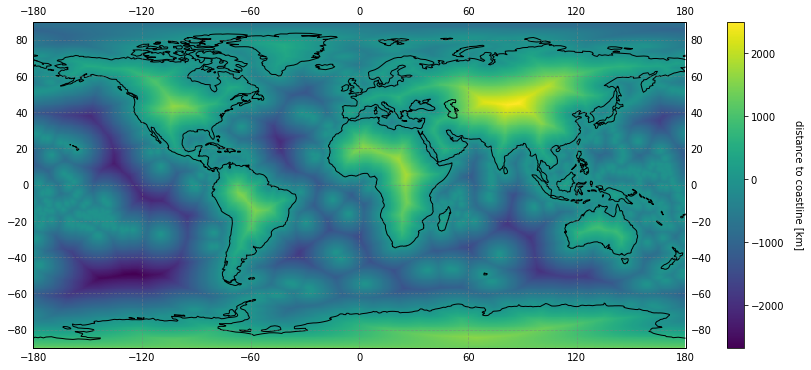

In [6]:
fig, ax = plot_z(dist_to_coast, lat, lon, 'distance to coastline [km]', coastlines=True, output=True)

plt.show(fig)

### elevation

Raw data from the Shuttle Radar Topography Mission (SRTM, https://www2.jpl.nasa.gov/srtm/). Downsampled to 0.5 degree resolution in QGIS using `gdalwarp` (`average` method).

In [7]:
elevation_nc = Dataset('data/elevation.nc')
elevation_nc.variables.keys()

odict_keys(['Band1', 'lat', 'lon'])

In [8]:
print('latitude  shape : {}'.format(np.shape(elevation_nc.variables['lat'][:].data)[0]))
print('longitude shape : {}'.format(np.shape(elevation_nc.variables['lon'][:].data)[0]))

latitude  shape : 360
longitude shape : 720


In [9]:
elevation = elevation_nc.variables['Band1'][:,:].data

elevation[elevation>1e35] = np.nan

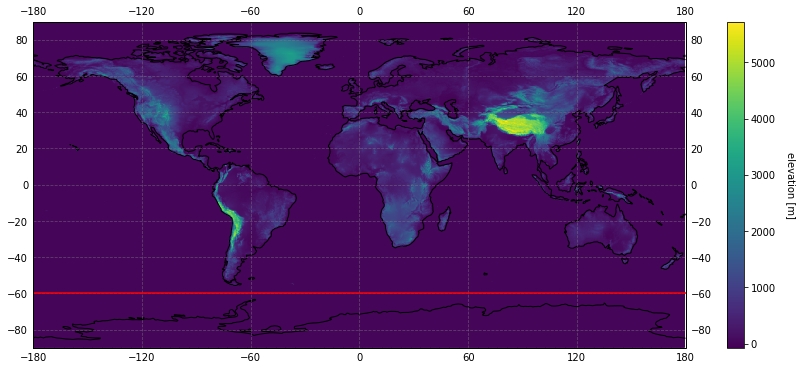

In [10]:
fig, ax = plot_z(elevation, lat, lon, 'elevation [m]', coastlines=True, output=True)

ax.axhline(-60, c='r')

plt.show(fig)

### temperature and runoff

Raw data from ERA5-Land (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview), taking the 'soil temperature level 1' and 'runoff' variables.

We need to downsample this data, as well as take the time averaged mean.

Grid setup in the raw data is described here: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference

In [11]:
# if set to true, perform the time averaging, interpolation, and save results to a .netcdf
# if false, just read in a previously time averaged and interpolated .netcdf
refresh = False

In [12]:
if refresh:
    # note that this file is IGNORED in this repository, due to its large size
    temp_runoff_nc = Dataset('data/temp-runoff.nc')
    temp_runoff_nc.variables.keys()

In [13]:
if refresh:
    temp_raw = temp_runoff_nc.variables['stl1'][:,:,:].data
    runoff_raw = temp_runoff_nc.variables['ro'][:,:,:].data

    temp_raw[temp_raw<-30000] = np.nan
    runoff_raw[runoff_raw<-30000] = np.nan

Plot just the first time slice:

In [14]:
if refresh:
    fig = plt.figure(figsize=(15,5))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

    im = ax.pcolormesh(temp_runoff_nc.variables['longitude'][:].data,
                       temp_runoff_nc.variables['latitude'][:].data,
                       temp_raw[0,:,:],
                       transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title('temperature', fontweight='bold')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('K', rotation=270, labelpad=20)

    plt.show(fig)

In [15]:
if refresh:
    fig = plt.figure(figsize=(15,5))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

    im = ax.pcolormesh(temp_runoff_nc.variables['longitude'][:].data,
                       temp_runoff_nc.variables['latitude'][:].data,
                       runoff_raw[0,:,:],
                       transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title('runoff', fontweight='bold')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

    plt.show(fig)

In [16]:
if refresh:
    # average over time
    temp_raw_mean = np.nanmean(temp_raw, axis=0)
    runoff_raw_mean = np.nanmean(runoff_raw, axis=0)

In [17]:
if refresh:
    # wrap around 180 instead of 0
    ERA_lon = temp_runoff_nc.variables['longitude'][:].data

    wrap_ind = np.int(len(ERA_lon)/2)

    ERA_lon_wrap = np.concatenate([ERA_lon[wrap_ind:],ERA_lon[:wrap_ind]])
    ERA_lon_wrap[ERA_lon_wrap>=180] = ERA_lon_wrap[ERA_lon_wrap>=180]-360

    temp_raw_mean_wrap = np.concatenate([temp_raw_mean[:,wrap_ind:],temp_raw_mean[:,:wrap_ind]],1)
    runoff_raw_mean_wrap = np.concatenate([runoff_raw_mean[:,wrap_ind:],runoff_raw_mean[:,:wrap_ind]],1)

In [18]:
if refresh:
    # set up the grid
    ERA_xx, ERA_yy = np.meshgrid(ERA_lon_wrap,
                                 temp_runoff_nc.variables['latitude'][:].data)

    ERA_xx = np.ravel(ERA_xx)
    ERA_yy = np.ravel(ERA_yy)

    xx, yy = np.meshgrid(lon, lat)

    # interpolate
    temp = griddata(points=(ERA_xx, ERA_yy),
                    values=np.ravel(temp_raw_mean_wrap),
                    xi=(xx, yy),
                    method ='linear')

    runoff = griddata(points=(ERA_xx, ERA_yy),
                      values=np.ravel(runoff_raw_mean_wrap),
                      xi=(xx, yy),
                      method ='linear')

In [19]:
if refresh:
    # initialize netCDF
    temp_nc = Dataset('data/temp.nc', 'w', format='NETCDF4')
    temp_nc.description = 'ERA5-Land temperature data, time averaged and interpolated.'

    # create dimensions
    temp_nc.createDimension('lon', 720)
    temp_nc.createDimension('lat', 360)

    # initialize variables
    lon_var = temp_nc.createVariable('lon', 'f', ('lon',))
    lat_var = temp_nc.createVariable('lat', 'f', ('lat',))
    tmp_var = temp_nc.createVariable('tmp', 'f', ('lat','lon',), fill_value=1e36)

    # attributes
    lon_var.long_name = 'longitude'
    lat_var.long_name = 'latitude'
    tmp_var.long_name = 'temperature'

    lon_var.units = 'degrees'
    lat_var.units = 'degrees'
    tmp_var.units = 'K'

    lon_var.axis = 'X'
    lat_var.axis = 'Y'

    # fill variables
    lon_var[:] = lon
    lat_var[:] = lat

    temp_masked = temp.copy()
    temp_masked[np.isnan(temp_masked)] = 1e36
    tmp_var[:,:] = temp_masked

    temp_nc.close()

In [20]:
if refresh:
    # initialize netCDF
    runoff_nc = Dataset('data/runoff.nc', 'w', format='NETCDF4')
    runoff_nc.description = 'ERA5-Land runoff data, time averaged and interpolated.'

    # create dimensions
    runoff_nc.createDimension('lon', 720)
    runoff_nc.createDimension('lat', 360)

    # initialize variables
    lon_var = runoff_nc.createVariable('lon', 'f', ('lon',))
    lat_var = runoff_nc.createVariable('lat', 'f', ('lat',))
    rnf_var = runoff_nc.createVariable('rnf', 'f', ('lat','lon',), fill_value=1e36)

    # attributes
    lon_var.long_name = 'longitude'
    lat_var.long_name = 'latitude'
    rnf_var.long_name = 'runoff'

    lon_var.units = 'degrees'
    lat_var.units = 'degrees'
    rnf_var.units = 'm'

    lon_var.axis = 'X'
    lat_var.axis = 'Y'

    # fill variables
    lon_var[:] = lon
    lat_var[:] = lat

    runoff_masked = runoff.copy()
    runoff_masked[np.isnan(runoff_masked)] = 1e36
    rnf_var[:,:] = runoff_masked

    runoff_nc.close()

In [21]:
if refresh==False:
    temp_nc = Dataset('data/temp.nc')
    runoff_nc = Dataset('data/runoff.nc')
    
    temp = temp_nc.variables['tmp'][:,:].data
    runoff = runoff_nc.variables['rnf'][:,:].data

    temp[temp>1e35] = np.nan
    runoff[runoff>1e35] = np.nan

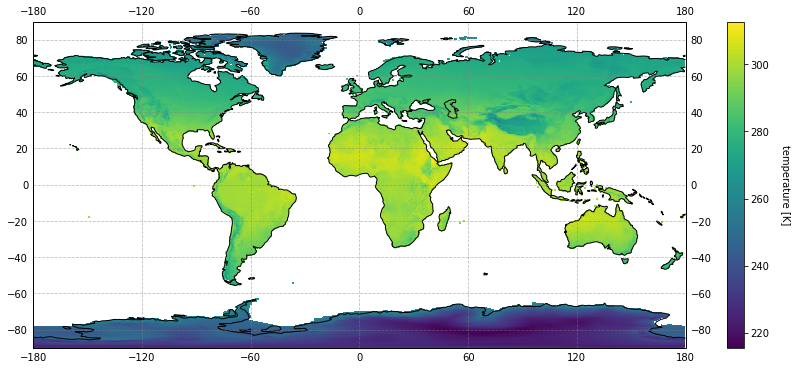

In [22]:
fig, ax = plot_z(temp, lat, lon, 'temperature [K]', coastlines=True, output=True)

plt.show(fig)

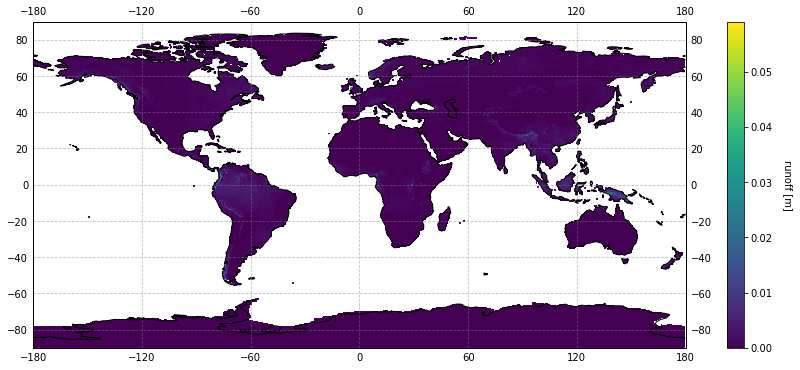

In [23]:
fig, ax = plot_z(runoff, lat, lon, 'runoff [m]', coastlines=True, output=True)

plt.show(fig)

### distance from western and eastern shorelines

A function to calculate the Vincenty distance (the distance between two (lat,lon) points on the WGS84 ellipsoid) from https://pypi.org/project/vincenty/

In [24]:
def vincenty(point1, point2, miles=False):
    """
    Vincenty's formula (inverse method) to calculate the distance (in
    kilometers or miles) between two points on the surface of a spheroid

    Doctests:
    >>> vincenty((0.0, 0.0), (0.0, 0.0))  # coincident points
    0.0
    >>> vincenty((0.0, 0.0), (0.0, 1.0))
    111.319491
    >>> vincenty((0.0, 0.0), (1.0, 0.0))
    110.574389
    >>> vincenty((0.0, 0.0), (0.5, 179.5))  # slow convergence
    19936.288579
    >>> vincenty((0.0, 0.0), (0.5, 179.7))  # failure to converge
    >>> boston = (42.3541165, -71.0693514)
    >>> newyork = (40.7791472, -73.9680804)
    >>> vincenty(boston, newyork)
    298.396057
    >>> vincenty(boston, newyork, miles=True)
    185.414657
    """
    # WGS 84
    a = 6378137  # meters
    f = 1 / 298.257223563
    b = 6356752.314245  # meters; b = (1 - f)a

    MILES_PER_KILOMETER = 0.621371

    MAX_ITERATIONS = 200
    CONVERGENCE_THRESHOLD = 1e-12  # .000,000,000,001
    
    # short-circuit coincident points
    if point1[0] == point2[0] and point1[1] == point2[1]:
        return 0.0

    U1 = math.atan((1 - f) * math.tan(math.radians(point1[0])))
    U2 = math.atan((1 - f) * math.tan(math.radians(point2[0])))
    L = math.radians(point2[1] - point1[1])
    Lambda = L

    sinU1 = math.sin(U1)
    cosU1 = math.cos(U1)
    sinU2 = math.sin(U2)
    cosU2 = math.cos(U2)

    for iteration in range(MAX_ITERATIONS):
        sinLambda = math.sin(Lambda)
        cosLambda = math.cos(Lambda)
        sinSigma = math.sqrt((cosU2 * sinLambda) ** 2 +
                             (cosU1 * sinU2 - sinU1 * cosU2 * cosLambda) ** 2)
        if sinSigma == 0:
            return 0.0  # coincident points
        cosSigma = sinU1 * sinU2 + cosU1 * cosU2 * cosLambda
        sigma = math.atan2(sinSigma, cosSigma)
        sinAlpha = cosU1 * cosU2 * sinLambda / sinSigma
        cosSqAlpha = 1 - sinAlpha ** 2
        try:
            cos2SigmaM = cosSigma - 2 * sinU1 * sinU2 / cosSqAlpha
        except ZeroDivisionError:
            cos2SigmaM = 0
        C = f / 16 * cosSqAlpha * (4 + f * (4 - 3 * cosSqAlpha))
        LambdaPrev = Lambda
        Lambda = L + (1 - C) * f * sinAlpha * (sigma + C * sinSigma *
                                               (cos2SigmaM + C * cosSigma *
                                                (-1 + 2 * cos2SigmaM ** 2)))
        if abs(Lambda - LambdaPrev) < CONVERGENCE_THRESHOLD:
            break  # successful convergence
    else:
        return None  # failure to converge

    uSq = cosSqAlpha * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + uSq / 16384 * (4096 + uSq * (-768 + uSq * (320 - 175 * uSq)))
    B = uSq / 1024 * (256 + uSq * (-128 + uSq * (74 - 47 * uSq)))
    deltaSigma = B * sinSigma * (cos2SigmaM + B / 4 * (cosSigma *
                 (-1 + 2 * cos2SigmaM ** 2) - B / 6 * cos2SigmaM *
                 (-3 + 4 * sinSigma ** 2) * (-3 + 4 * cos2SigmaM ** 2)))
    s = b * A * (sigma - deltaSigma)

    s /= 1000  # meters to kilometers
    if miles:
        s *= MILES_PER_KILOMETER  # kilometers to miles

    return round(s, 6)

## Exploration

First, create a dataframe that stores all the values:

In [25]:
lat_dim = len(lat)
lon_dim = len(lon)

lat_col = np.zeros(lat_dim*lon_dim)
lon_col = np.zeros(lat_dim*lon_dim)
dist_to_coast_col = np.zeros(lat_dim*lon_dim)
elevation_col = np.zeros(lat_dim*lon_dim)
temp_col = np.zeros(lat_dim*lon_dim)
runoff_col = np.zeros(lat_dim*lon_dim)
i_col = np.zeros(lat_dim*lon_dim)
j_col = np.zeros(lat_dim*lon_dim)

for i in range(lat_dim):
    for j in range(lon_dim):
        col_ind = i*lon_dim + j
        
        lat_col[col_ind] = lat[i]
        lon_col[col_ind] = lon[j]
        dist_to_coast_col[col_ind] = dist_to_coast[i,j]
        elevation_col[col_ind] = elevation[i,j]
        temp_col[col_ind] = temp[i,j]
        runoff_col[col_ind] = runoff[i,j]
        i_col[col_ind] = i
        j_col[col_ind] = j
        
df = pd.DataFrame({'lat':lat_col,
                   'lon':lon_col,
                   'dist_to_coast':dist_to_coast_col,
                   'elevation':elevation_col,
                   'temp':temp_col,
                   'runoff':runoff_col,
                   'i':i_col,
                   'j':j_col})

# get rid of any rows with NaN
df.dropna(axis=0, how='any', inplace=True)

# get rid of Antarctica rows, since we have no elevation data for them
df = df[df['lat']>-60]

# reset index
df.reset_index(drop=True, inplace=True)

# fix some units
df['dist_to_coast'] = df['dist_to_coast']*1000
df['temp'] = df['temp'] - 273.15

# log transform the runoff, adding a small constant value to deal with the zeroes
min_runoff = np.min(df[df['runoff']!=0]['runoff'])
df['runoff'] = np.log10(df['runoff']+min_runoff)

print(len(df))
df.head()

60454


,lat,lon,dist_to_coast,elevation,temp,runoff,i,j
0,-55.25,-68.75,2000.0,273.780975,3.352655,-2.421345,69.0,222.0
1,-54.75,-70.75,1000.0,219.787689,4.528375,-2.178703,70.0,218.0
2,-54.75,-70.25,2000.0,406.302887,1.761591,-2.077110,70.0,219.0
3,-54.75,-69.75,2000.0,586.687195,-1.703101,-2.191488,70.0,220.0
4,-54.75,-69.25,5000.0,639.092468,-3.082892,-2.494872,70.0,221.0


In [26]:
explore_cols = ['lat','lon','dist_to_coast','elevation','temp','runoff']

In [27]:
df[explore_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60454 entries, 0 to 60453
Data columns (total 6 columns):
lat              60454 non-null float64
lon              60454 non-null float64
dist_to_coast    60454 non-null float64
elevation        60454 non-null float64
temp             60454 non-null float64
runoff           60454 non-null float64
dtypes: float64(6)
memory usage: 2.8 MB


In [28]:
df[explore_cols].describe()

,lat,lon,dist_to_coast,elevation,temp,runoff
count,60454.000000,60454.000000,6.045400e+04,60454.000000,60454.000000,60454.000000
mean,32.927077,17.705975,5.417712e+05,665.715002,11.885533,-3.976931
std,31.884164,84.327727,5.145523e+05,819.504762,13.552863,1.427466
min,-55.250000,-179.750000,-4.500000e+04,-75.565979,-30.979666,-8.226129
25%,10.250000,-61.250000,1.240000e+05,168.700146,2.779825,-4.587915
50%,40.250000,27.250000,3.820000e+05,382.149155,11.088052,-3.472895
75%,59.750000,89.750000,8.280000e+05,849.367722,24.696878,-3.019789
max,83.250000,179.750000,2.497000e+06,5723.041992,39.514154,-1.228807


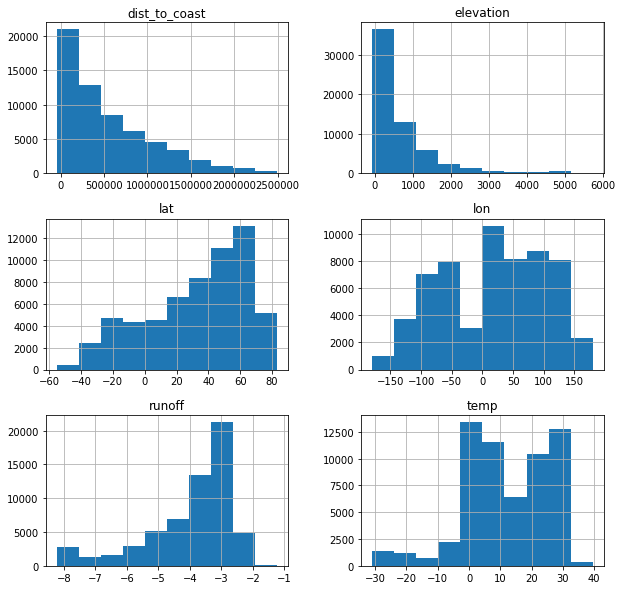

In [29]:
df[explore_cols].hist(figsize=(10,10))

plt.show()

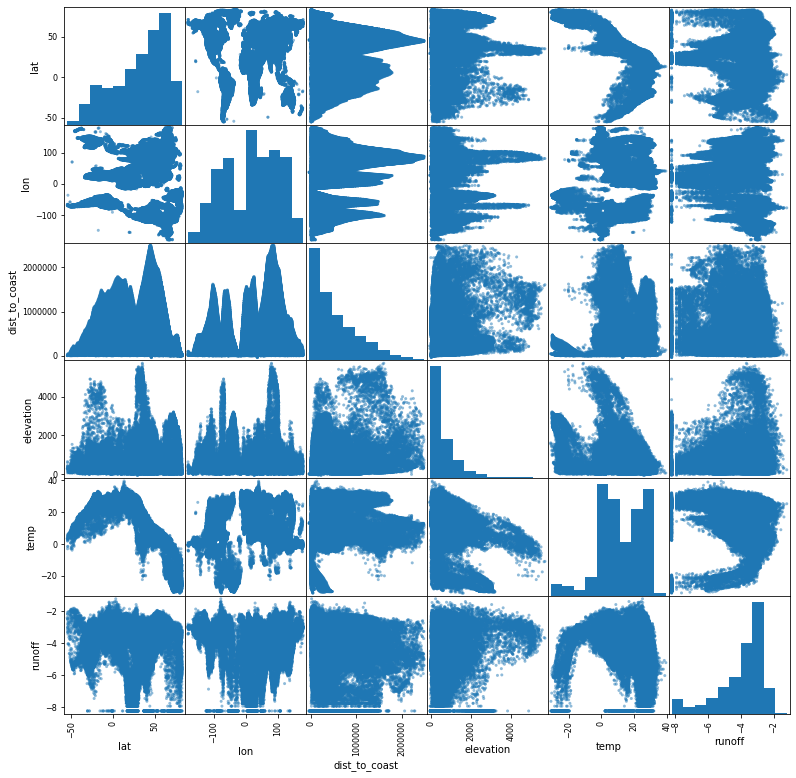

In [30]:
scatter_matrix(df[explore_cols], figsize=(13,13))

plt.show()

In [31]:
df[explore_cols].corr()

,lat,lon,dist_to_coast,elevation,temp,runoff
lat,1.000000,-0.052564,-0.032681,-0.005033,-0.773400,0.009990
lon,-0.052564,1.000000,0.183625,-0.007918,0.092265,-0.017059
dist_to_coast,-0.032681,0.183625,1.000000,0.230907,0.122230,-0.161981
elevation,-0.005033,-0.007918,0.230907,1.000000,-0.266911,-0.122155
temp,-0.773400,0.092265,0.122230,-0.266911,1.000000,-0.042958
runoff,0.009990,-0.017059,-0.161981,-0.122155,-0.042958,1.000000


No linear relationships observable, but there is pattern in the data.

## Predictors

To try:
* linear regression
* random forest

Preprocess the data:

In [32]:
# train test split
train, test = train_test_split(df, test_size=0.2, random_state=22)

# separate X and Y
x_cols = ['lat','dist_to_coast','elevation']

train_x = train[x_cols]
test_x = test[x_cols]

train_temp = train['temp']
test_temp = test['temp']

train_runoff = train['runoff']
test_runoff = test['runoff']

# get lat, lon, and indices before standardizing
train_lat = train['lat']
train_lon = train['lon']
test_lat = test['lat']
test_lon = test['lon']

train_i = train['i']
train_j = train['j']
test_i = test['i']
test_j = test['j']

# standardize
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

Scoring metric:

In [33]:
def get_RMSE(y, y_prediction):
    RMSE = np.sqrt(mean_squared_error(y, y_prediction))
    return RMSE

Store RMSE's:

In [34]:
RMSEs = pd.DataFrame({'predictor':[],'temp':[],'runoff':[]})

The train/test split:

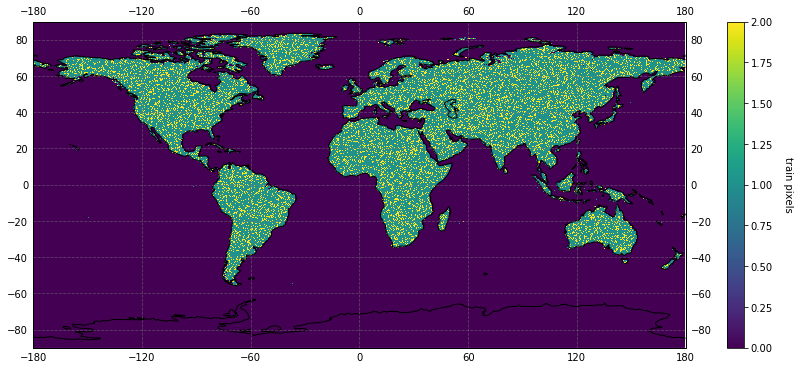

In [35]:
train_test_map = np.zeros((lat_dim, lon_dim))

for i in range(len(train)):
    train_test_map[int(train_i.iloc[i]), int(train_j.iloc[i])] = 1
    
for i in range(len(test)):
    train_test_map[int(test_i.iloc[i]), int(test_j.iloc[i])] = 2

fig, ax = plot_z(train_test_map, lat, lon, 'train pixels', coastlines=True, output=True)

plt.show(fig)

### baseline

Just predict the mean of the data and see how well we do.

In [36]:
temp_RMSE_baseline = get_RMSE(test_temp, np.ones(len(test_temp))*np.mean(test_temp))
runoff_RMSE_baseline = get_RMSE(test_runoff, np.ones(len(test_runoff))*np.mean(test_runoff))

RMSEs.loc[0,'predictor'] = 'baseline'
RMSEs.loc[0,'temp'] = temp_RMSE_baseline
RMSEs.loc[0,'runoff'] = runoff_RMSE_baseline

RMSEs

,predictor,temp,runoff
0,baseline,13.502483,1.435323


### linear regression

#### temperature

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_temp)
test_temp_lin_reg_prediction = lin_reg.predict(test_x)

temp_RMSE_lin_reg = get_RMSE(test_temp, test_temp_lin_reg_prediction)

for i in range(len(x_cols)):
    print(x_cols[i] + ' : {:.2f}'.format(lin_reg.coef_[i]))

lat : -10.44
dist_to_coast : 2.27
elevation : -4.20


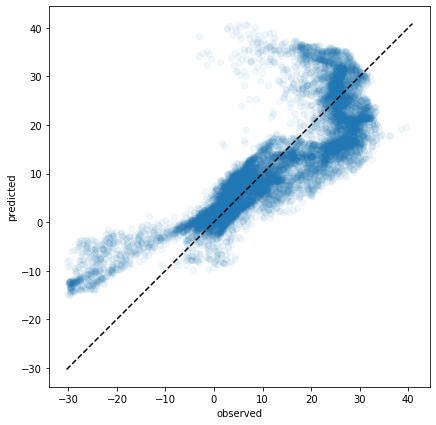

In [38]:
fig, ax = plt.subplots(figsize=(7,7))

one_to_one = [np.min([np.min(test_temp), np.min(test_temp_lin_reg_prediction)]),
              np.max([np.min(test_temp), np.max(test_temp_lin_reg_prediction)])]

ax.scatter(test_temp, test_temp_lin_reg_prediction, alpha=0.05)
ax.plot(one_to_one, one_to_one, ls='--', c='k')

ax.set_aspect('equal', 'box')

ax.set_xlabel('observed')
ax.set_ylabel('predicted')

plt.show(fig)

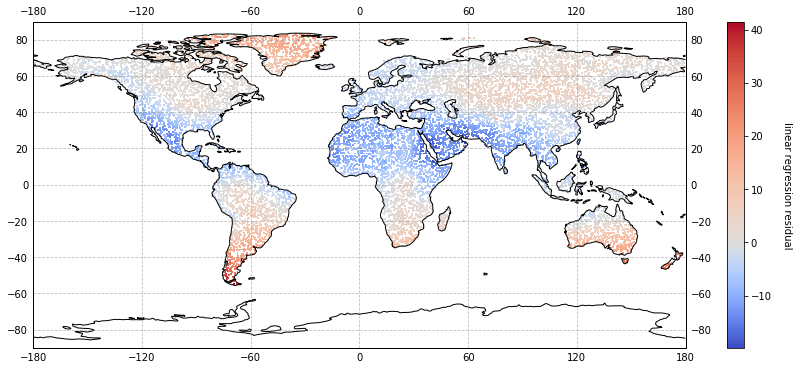

In [39]:
test_temp_lin_reg_residual = test_temp_lin_reg_prediction - test_temp

temp_lin_reg_residual_map = np.empty((lat_dim, lon_dim)) * np.nan

for i in range(len(test)):
    temp_lin_reg_residual_map[int(test_i.iloc[i]), int(test_j.iloc[i])] = test_temp_lin_reg_residual.iloc[i]
    
fig, ax = plot_z(temp_lin_reg_residual_map, lat, lon, 'linear regression residual',
                 center=True, coastlines=True, output=True)

plt.show(fig)

#### runoff

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_runoff)
test_runoff_lin_reg_prediction = lin_reg.predict(test_x)

runoff_RMSE_lin_reg = get_RMSE(test_runoff, test_runoff_lin_reg_prediction)

for i in range(len(x_cols)):
    print(x_cols[i] + ' : {:.2f}'.format(lin_reg.coef_[i]))

lat : 0.01
dist_to_coast : -0.20
elevation : -0.12


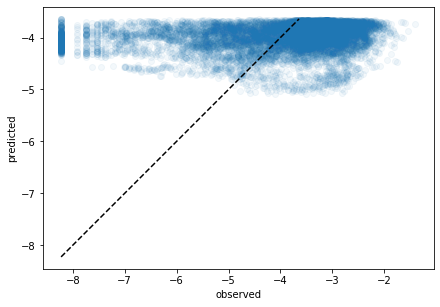

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

one_to_one = [np.min([np.min(test_runoff), np.min(test_runoff_lin_reg_prediction)]),
              np.max([np.min(test_runoff), np.max(test_runoff_lin_reg_prediction)])]

ax.scatter(test_runoff, test_runoff_lin_reg_prediction, alpha=0.05)
ax.plot(one_to_one, one_to_one, ls='--', c='k')

ax.set_aspect('equal', 'box')

ax.set_xlabel('observed')
ax.set_ylabel('predicted')

plt.show(fig)

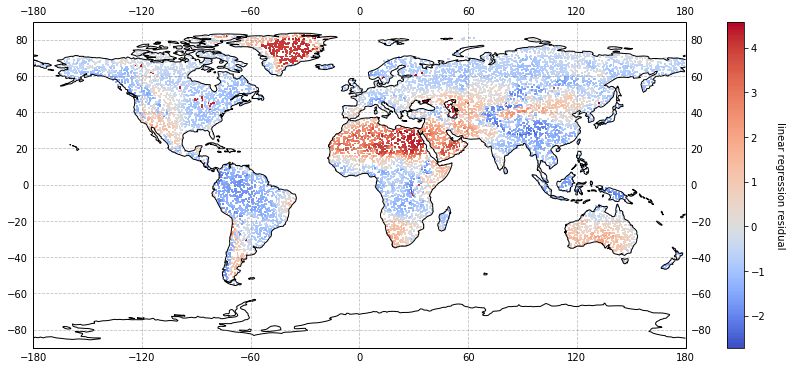

In [42]:
test_runoff_lin_reg_residual = test_runoff_lin_reg_prediction - test_runoff

runoff_lin_reg_residual_map = np.empty((lat_dim, lon_dim)) * np.nan

for i in range(len(test)):
    runoff_lin_reg_residual_map[int(test_i.iloc[i]), int(test_j.iloc[i])] = test_runoff_lin_reg_residual.iloc[i]
    
fig, ax = plot_z(runoff_lin_reg_residual_map, lat, lon, 'linear regression residual',
                 center=True, coastlines=True, output=True)

plt.show(fig)

In [43]:
RMSEs.loc[1,'predictor'] = 'linear regression'
RMSEs.loc[1,'temp'] = temp_RMSE_lin_reg
RMSEs.loc[1,'runoff'] = runoff_RMSE_lin_reg

RMSEs

,predictor,temp,runoff
0,baseline,13.502483,1.435323
1,linear regression,7.449255,1.410050


### random forest

#### temperature

In [44]:
# if set to true, perform GridSearchCV, and save results and best performing model
# if false, just read in previous results and best performing model
refresh = False

In [45]:
if refresh:
    # grid search
    param_grid = [{'n_estimators': [200, 300, 400, 500, 600, 700],
                   'max_depth': [30, 40, 50, 60]},]

    RFR = RandomForestRegressor(n_jobs=-1, random_state=1992)

    cv = 5
    grid_search = GridSearchCV(RFR, param_grid, cv=cv,
                               scoring='neg_mean_squared_error')

    grid_search.fit(train_x, train_temp)

    # convert results into a dataframe and save
    grid_search_results = pd.DataFrame(grid_search.cv_results_)
    grid_search_results.to_csv('output/temp_grid_search_results.csv', index=False)

    # approximate run time
    print('run time : {:.2f} mins'.format((np.sum(grid_search_results['mean_fit_time'])*cv)/60))
    
    # get the best estimator and fit
    temp_RFR = grid_search.best_estimator_
    temp_RFR.fit(train_x, train_temp)
    
    # save the model
    dump(grid_search.best_estimator_, 'output/temp_RFR.joblib')
    
else:
    grid_search_results = pd.read_csv('output/temp_grid_search_results.csv')
    temp_RFR = load('output/temp_RFR.joblib')

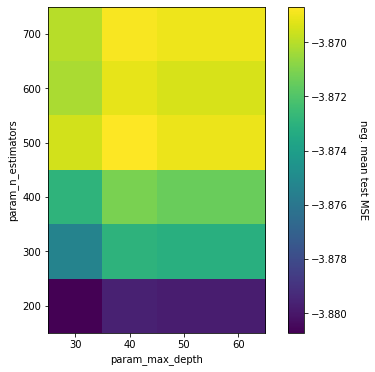

In [46]:
grid_search_results_pivot = grid_search_results.pivot(index='param_n_estimators',
                                                      columns='param_max_depth',
                                                      values='mean_test_score')

# plot
fig, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(grid_search_results_pivot.values, origin='lower')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('neg. mean test MSE', rotation=-90, labelpad=20)

ax.set_xlabel(grid_search_results_pivot.columns.name)
ax.set_ylabel(grid_search_results_pivot.index.name)

ax.set_xticks(np.arange(len(grid_search_results_pivot.columns)))
ax.set_xticklabels(grid_search_results_pivot.columns)

ax.set_yticks(np.arange(len(grid_search_results_pivot.index)))
ax.set_yticklabels(grid_search_results_pivot.index)

plt.show(fig)

In [47]:
test_temp_RFR_prediction = temp_RFR.predict(test_x)

temp_RMSE_RFR = get_RMSE(test_temp, test_temp_RFR_prediction)
print(temp_RMSE_RFR)

1.9134929676138854


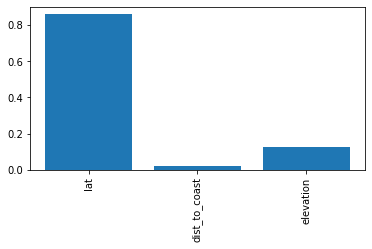

In [48]:
fig, ax = plt.subplots(figsize=(6,3))

bar_x = np.arange(len(x_cols))

ax.bar(bar_x, temp_RFR.feature_importances_)

ax.set_xticks(bar_x)
ax.set_xticklabels(x_cols, rotation=90)

plt.show(fig)

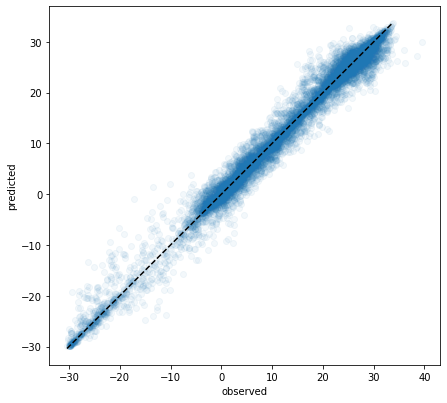

In [49]:
fig, ax = plt.subplots(figsize=(7,7))

one_to_one = [np.min([np.min(test_temp), np.min(test_temp_RFR_prediction)]),
              np.max([np.min(test_temp), np.max(test_temp_RFR_prediction)])]

ax.scatter(test_temp, test_temp_RFR_prediction, alpha=0.05)
ax.plot(one_to_one, one_to_one, ls='--', c='k')

ax.set_aspect('equal', 'box')

ax.set_xlabel('observed')
ax.set_ylabel('predicted')

plt.show(fig)

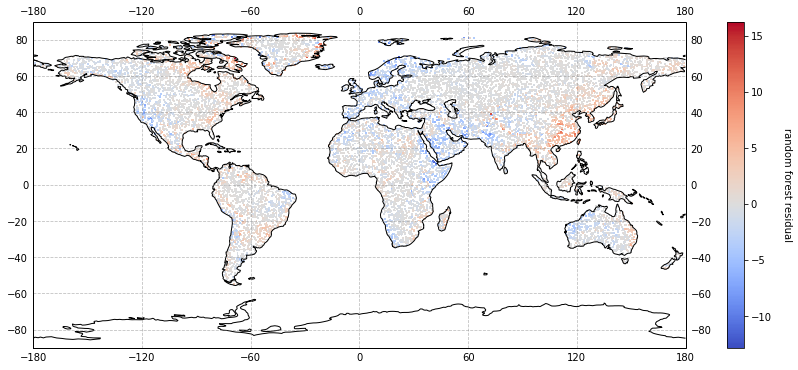

In [50]:
test_temp_RFR_residual = test_temp_RFR_prediction - test_temp

temp_RFR_residual_map = np.empty((lat_dim, lon_dim)) * np.nan

for i in range(len(test)):
    temp_RFR_residual_map[int(test_i.iloc[i]), int(test_j.iloc[i])] = test_temp_RFR_residual.iloc[i]
    
fig, ax = plot_z(temp_RFR_residual_map, lat, lon, 'random forest residual',
                 center=True, coastlines=True, output=True)

plt.show(fig)

#### runoff

In [51]:
# if set to true, perform GridSearchCV, and save results and best performing model
# if false, just read in previous results and best performing model
refresh = False

In [52]:
if refresh:
    # grid search
    param_grid = [{'n_estimators': [200, 300, 400, 500, 600, 700],
                   'max_depth': [30, 40, 50, 60]},]

    RFR = RandomForestRegressor(n_jobs=-1, random_state=1992)

    cv = 5
    grid_search = GridSearchCV(RFR, param_grid, cv=cv,
                               scoring='neg_mean_squared_error')

    grid_search.fit(train_x, train_runoff)

    # convert results into a dataframe and save
    grid_search_results = pd.DataFrame(grid_search.cv_results_)
    grid_search_results.to_csv('output/runoff_grid_search_results.csv', index=False)

    # approximate run time
    print('run time : {:.2f} mins'.format((np.sum(grid_search_results['mean_fit_time'])*cv)/60))
    
    # get the best estimator and fit
    runoff_RFR = grid_search.best_estimator_
    runoff_RFR.fit(train_x, train_runoff)
    
    # save the model
    dump(grid_search.best_estimator_, 'output/runoff_RFR.joblib')
    
else:
    grid_search_results = pd.read_csv('output/runoff_grid_search_results.csv')
    runoff_RFR = load('output/runoff_RFR.joblib')

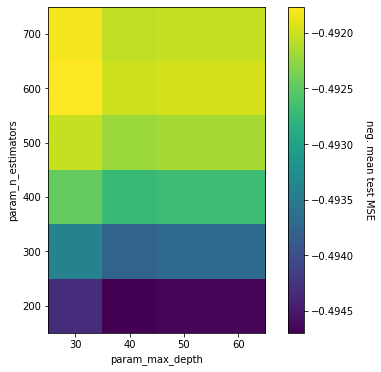

In [53]:
grid_search_results_pivot = grid_search_results.pivot(index='param_n_estimators',
                                                      columns='param_max_depth',
                                                      values='mean_test_score')

# plot
fig, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(grid_search_results_pivot.values, origin='lower')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('neg. mean test MSE', rotation=-90, labelpad=20)

ax.set_xlabel(grid_search_results_pivot.columns.name)
ax.set_ylabel(grid_search_results_pivot.index.name)

ax.set_xticks(np.arange(len(grid_search_results_pivot.columns)))
ax.set_xticklabels(grid_search_results_pivot.columns)

ax.set_yticks(np.arange(len(grid_search_results_pivot.index)))
ax.set_yticklabels(grid_search_results_pivot.index)

plt.show(fig)

In [54]:
test_runoff_RFR_prediction = runoff_RFR.predict(test_x)

runoff_RMSE_RFR = get_RMSE(test_runoff, test_runoff_RFR_prediction)
print(runoff_RMSE_RFR)

0.7155692919581004


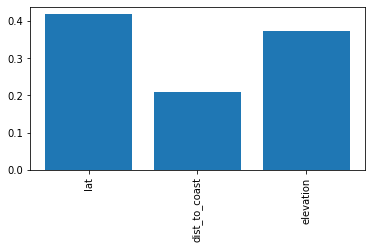

In [55]:
fig, ax = plt.subplots(figsize=(6,3))

bar_x = np.arange(len(x_cols))

ax.bar(bar_x, runoff_RFR.feature_importances_)

ax.set_xticks(bar_x)
ax.set_xticklabels(x_cols, rotation=90)

plt.show(fig)

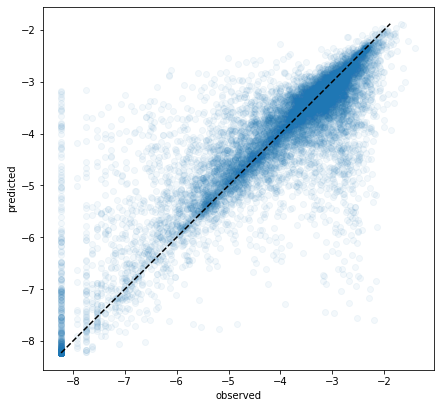

In [56]:
fig, ax = plt.subplots(figsize=(7,7))

one_to_one = [np.min([np.min(test_runoff), np.min(test_runoff_RFR_prediction)]),
              np.max([np.min(test_runoff), np.max(test_runoff_RFR_prediction)])]

ax.scatter(test_runoff, test_runoff_RFR_prediction, alpha=0.05)
ax.plot(one_to_one, one_to_one, ls='--', c='k')

ax.set_aspect('equal', 'box')

ax.set_xlabel('observed')
ax.set_ylabel('predicted')

plt.show(fig)

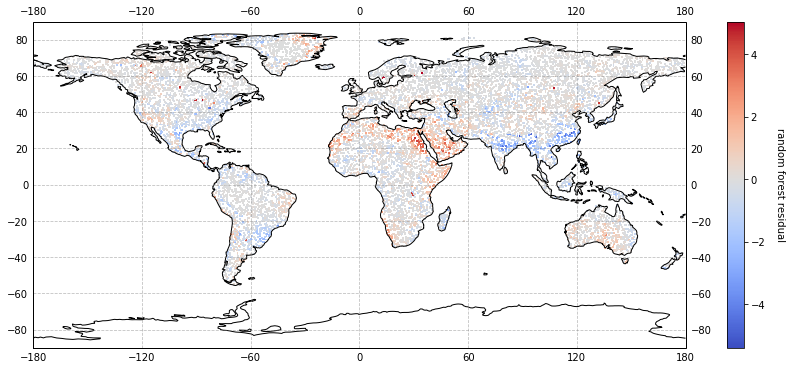

In [57]:
test_runoff_RFR_residual = test_runoff_RFR_prediction - test_runoff

runoff_RFR_residual_map = np.empty((lat_dim, lon_dim)) * np.nan

for i in range(len(test)):
    runoff_RFR_residual_map[int(test_i.iloc[i]), int(test_j.iloc[i])] = test_runoff_RFR_residual.iloc[i]
    
fig, ax = plot_z(runoff_RFR_residual_map, lat, lon, 'random forest residual',
                 center=True, coastlines=True, output=True)

plt.show(fig)

In [58]:
RMSEs.loc[2,'predictor'] = 'random forest'
RMSEs.loc[2,'temp'] = temp_RMSE_RFR
RMSEs.loc[2,'runoff'] = runoff_RMSE_RFR

RMSEs

,predictor,temp,runoff
0,baseline,13.502483,1.435323
1,linear regression,7.449255,1.410050
2,random forest,1.913493,0.715569
